In [1]:
import numpy as np
import xsimlab as xs
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# This below magically works!!!

In [253]:
# GOAL: test whether groups can be accumulated in other class, which is then referenced by component

@xs.process
class INIT:
    """Create a 1-dimensional, array of NPZD component states and labels."""
    numberofcomps = xs.variable(description="total length", static=True) # here all the label & state inputs enter, and they get flattened below, and assigned
    components = xs.index(dims="C") #x!
    def initialize(self):
        self.components = np.arange(0., self.numberofcomps)  

@xs.process
class Component:
    fluxes = xs.group('flux')
    value = xs.variable(dims='C', intent='inout')
    
    # PARAMETER
    v = xs.variable(dims=[(), "C"], description="velocity")
    
    @xs.runtime(args="step_delta")
    def run_step(self, dt):
        self._delta = sum((v for v in self.fluxes)) * dt

    @xs.runtime(args="step_delta")
    def finalize_step(self, dt):
        self.value += self._delta * self.value
        
    
    
@xs.process
class InitC:
    """Initialize `u` profile using a Gaussian pulse."""

    components = xs.foreign(INIT, "components")
    value = xs.foreign(Component, "value", intent="out")

    def initialize(self):
        self.value = np.array([(i+1)*2 for i in range(len(self.components))], dtype='float64')
        
#
        
@xs.process
class oneFlux:
    #c_state = xs.foreign(ProfileC, "c_state")
    value = xs.foreign(Component, 'value', intent='in')
    
    v = xs.foreign(Component, 'v') #xs.variable(dims=[(), "C"], description="velocity")
    
    flux_out = xs.variable(dims="C", intent="out", groups="flux")

    def run_step(self):
        #print('oneFlux','val',self.value)
        growth= np.array([1/10])
        self.flux_out = growth

@xs.process
class twoFlux:
    #c_state = xs.foreign(ProfileC, "c_state")
    value = xs.foreign(Component, 'value', intent='in')
    
    v = xs.foreign(Component, 'v') #xs.variable(dims=[(), "C"], description="velocity")
    
    flux_out = xs.variable(dims="C", intent="out", groups="flux")

    def run_step(self):
        #print('oneFlux','val',self.value)
        growth= np.array([1/20])
        self.flux_out = - growth * self.value / 5
    
        
@xs.process
class checkVal:
    val = xs.foreign(Component, 'value', intent='in')
    
    def run_step(self):
        print(self.val)
#The answer is NO

#but variables can be initialized with xs.foreign as well!
#is that maybe useful?? 

In [254]:
test = xs.Model({'C':Component, 'F':oneFlux, 'f2':twoFlux, 'InitC':InitC, 'INIT':INIT})

In [255]:
test

<xsimlab.Model (5 processes, 2 inputs)>
INIT
    numberofcomps     [in] total length
InitC
f2
F
C
    v                 [in] () or ('C',) velocity

In [256]:
testin_ds = xs.create_setup(
     model=test,
     clocks={
         'time': np.linspace(0., 50., 5001)#,
         #'otime': [0, 0.1, 0.5, 1]
     },
     master_clock='time',
     input_vars={
        'INIT__numberofcomps':5,  #'grid__numberofcomps':3,
         'C__v':1
         #'advect__v': 1.
     },
     output_vars={
         'C__value':'time'#'profile__c_state': 'time'
     }
 )

In [257]:
with test:
    out= testin_ds.xsimlab.run()

In [258]:
out

<xarray.Dataset>
Dimensions:              (C: 5, time: 5001)
Coordinates:
  * time                 (time) float64 0.0 0.01 0.02 0.03 ... 49.98 49.99 50.0
Dimensions without coordinates: C
Data variables:
    C__v                 int64 1
    C__value             (time, C) float64 2.0 4.0 6.0 8.0 ... 9.955 9.983 10.0
    INIT__numberofcomps  int64 5
    components           (C) float64 0.0 1.0 2.0 3.0 4.0

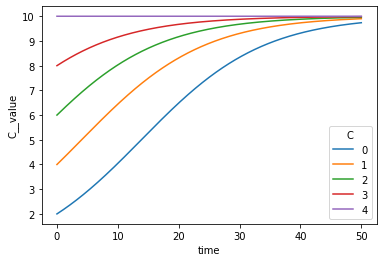

In [259]:
out.C__value.plot.line(x = 'time')

# This below does not work! cyclical dependencies.. but why?

In [38]:
# This definitely also makes sense, but just as construction help for future components (and building block of the current ones)
@xs.process
class Time:
    days = xs.variable(dims='time', description='time in days')
    # for indexing xarray IO objects
    # NOTE: this is what allows storing the output along time properly even when using odeint!
    time = xs.index(dims='time', description='time in days')
    
    def initialize(self):
        self.time = self.days

@xs.process
class Component:
    """Base class encoding behaviour for a component of a ecosystem.
        subclass needs to have implemented:
        self.num, self.component_label, self.init, 
        
    """
    def initialize(self):
        if self.num:
            self.label = np.array([f"{self.component_label}-{i+1}" for i in range(self.num)])
            self.init = np.array([self.initVal for i in range(self.num)])
        else:
            self.label = self.component_label
            self.init = self.initVal
        self.c_state = self.init
        print(self.label)
        print(self.init)
        
    def run_step(self):
        self._delta_c = sum((v for v in self.c_fluxes))

    def finalize_step(self):
        self.c_state += self._delta_c

@xs.process
class Nutrient(Component):
    """"""
    component_label = xs.variable(default='N', groups='component-label', static=True)
    label = xs.index(dims='N')
    init = xs.variable(dims='N',intent='out')
    
    num = xs.variable(intent='in', static=True, description='number of Phytoplankton')
    initVal = xs.variable(default=1)
    
    fluxes = xs.group('n_flux')
    state = xs.variable(dims='N', groups='state-variable', intent='out', description='component array', attrs={'units': 'µM N'})

            
@xs.process
class Phytoplankton(Component):
    """"""
    component_label = xs.variable(default='P', groups='component-label', static=True)
    label = xs.index(dims='P')
    init = xs.variable(dims='P',intent='out')
    
    initVal = xs.variable(default=1)
    
    fluxes = xs.group('p_flux')
    state = xs.variable(dims='P', groups='state-variable', intent='out', description='component array', attrs={'units': 'µM N'})
    
    # PARAMETERS
    num = xs.variable(intent='in', groups='parameters', static=True, description='number of Phytoplankton')
    halfsat = xs.variable(dims=[(), 'P'], groups='parameters')

@xs.process
class PhytoplanktonGrowth:
    """"""
    growth = xs.variable(
        dims='P',
        intent='out',
        groups=['p_flux'],
        description='phytoplankton growth, under light & nutrient limitation'
    )
    
@xs.process
class NutrientUptake(PhytoplanktonGrowth):
    """"""
    N = xs.foreign(Nutrient, 'state')
    P = xs.foreign(Phytoplankton, 'state')
    P_halfsat = xs.foreign(Phytoplankton, 'halfsat')
    
    def run_step(self):
        self.growth = self.N / (self.P_halfsat + self.N) * self.P
    
    
@xs.process
class Forcing:
    """Sum up all forcing processes and their effects, respectively.
    """
    pass
    

class NutrientSource(Forcing):
    """Chemostat constant nutrient inflow from one direction"""
    forcing_flux = xs.variable(
        dims=[(), 'N'],
        intent='out',
        groups='n_flux',
        description='constant nutrient influx'
    )

    #N = xs.foreign(Nutrient, 'state')
    
    #@xs.runtime(args='step_delta')
    def run_step(self):
        self.forcing_flux = 0.1


In [39]:
xs.Model({'N':Nutrient, 'P':Phytoplankton, 'N_Uptake':NutrientUptake, 'N_source':NutrientSource})

<xsimlab.Model (4 processes, 9 inputs)>
N
    component_label     [in]
    initVal             [in]
    state            [inout] ('N',) component array
    num                 [in] number of Phytoplankton
N_Uptake
P
    state            [inout] ('P',) component array
    num                 [in] number of Phytoplankton
    halfsat             [in] () or ('P',) 
    initVal             [in]
    component_label     [in]
N_source

# Below HERE I will try to fix it!

In [40]:
# This definitely also makes sense, but just as construction help for future components (and building block of the current ones)
@xs.process
class Time:
    days = xs.variable(dims='time', description='time in days')
    # for indexing xarray IO objects
    # NOTE: this is what allows storing the output along time properly even when using odeint!
    time = xs.index(dims='time', description='time in days')
    
    def initialize(self):
        self.time = self.days

@xs.process
class Component:
    """Base class encoding behaviour for a component of a ecosystem.
        subclass needs to have implemented:
        self.num, self.component_label, self.init, 
        
    """
    def initialize(self):
        if self.num:
            self.label = np.array([f"{self.component_label}-{i+1}" for i in range(self.num)])
            self.init = np.array([self.initVal for i in range(self.num)])
        else:
            self.label = self.component_label
            self.init = self.initVal
        self.c_state = self.init
        print(self.label)
        print(self.init)
        
    def run_step(self):
        self._delta_c = sum((v for v in self.c_fluxes))

    def finalize_step(self):
        self.c_state += self._delta_c

@xs.process
class Nutrient(Component):
    """"""
    component_label = xs.variable(default='N', groups='component-label', static=True)
    label = xs.index(dims='N')
    init = xs.variable(dims='N',intent='out')
    
    num = xs.variable(intent='in', static=True, description='number of Phytoplankton')
    initVal = xs.variable(default=1)
    
    fluxes = xs.group('n_flux')
    state = xs.variable(dims='N', groups='state-variable', intent='inout', description='component array', attrs={'units': 'µM N'})

            
@xs.process
class Phytoplankton(Component):
    """"""
    component_label = xs.variable(default='P', groups='component-label', static=True)
    label = xs.index(dims='P')
    init = xs.variable(dims='P',intent='out')
    
    initVal = xs.variable(default=1)
    
    fluxes = xs.group('p_flux')
    state = xs.variable(dims='P', groups='state-variable', intent='inout', description='component array', attrs={'units': 'µM N'})
    
    # PARAMETERS
    num = xs.variable(intent='in', groups='parameters', static=True, description='number of Phytoplankton')
    halfsat = xs.variable(dims=[(), 'P'], groups='parameters')

@xs.process
class PhytoplanktonGrowth:
    """"""
    growth = xs.variable(
        dims='P',
        intent='out',
        groups=['p_flux'],
        description='phytoplankton growth, under light & nutrient limitation'
    )
    
@xs.process
class NutrientUptake(PhytoplanktonGrowth):
    """"""
    N = xs.foreign(Nutrient, 'state')
    P = xs.foreign(Phytoplankton, 'state')
    P_halfsat = xs.foreign(Phytoplankton, 'halfsat')
    
    def run_step(self):
        self.growth = self.N / (self.P_halfsat + self.N) * self.P
    
    
@xs.process
class Forcing:
    """Sum up all forcing processes and their effects, respectively.
    """
    pass
    

class NutrientSource(Forcing):
    """Chemostat constant nutrient inflow from one direction"""
    forcing_flux = xs.variable(
        dims=[(), 'N'],
        intent='out',
        groups='n_flux',
        description='constant nutrient influx'
    )

    #N = xs.foreign(Nutrient, 'state')
    
    #@xs.runtime(args='step_delta')
    def run_step(self):
        self.forcing_flux = 0.1


In [41]:
xs.Model({'N':Nutrient, 'P':Phytoplankton, 'N_Uptake':NutrientUptake, 'N_source':NutrientSource})

<xsimlab.Model (4 processes, 9 inputs)>
N
    component_label     [in]
    initVal             [in]
    state            [inout] ('N',) component array
    num                 [in] number of Phytoplankton
N_Uptake
P
    state            [inout] ('P',) component array
    num                 [in] number of Phytoplankton
    halfsat             [in] () or ('P',) 
    initVal             [in]
    component_label     [in]
N_source